In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
from puzzle import *
import global_values
from displaying import *
from groups import *


In [2]:
image_path = "disney_puzzle/aladin.jpg" 
# image_path = "angry.jpg"
output_folder = "fragments"
global_values.COL_NR = 4
global_values.ROW_NR = 4
fragments, tile_h, tile_w = divide_image(image_path, output_folder, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)

sides_comparisons = create_sides_comparisons(fragments)
sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(fragments, c.side2, c.side1)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp



100%|██████████| 15/15 [00:00<00:00, 309.62it/s]


In [3]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
# show_all_groups(groups, fragments)
print(fragment_idx_to_group_idx)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


0.004382742714447704
Sides Comp: Score=0.004382742714447704 Fragment_idx1=4, Side_idx1=1; fragment_idx2=5, side_idx2=3
0.005209909990640781
Sides Comp: Score=0.005210173285807594 Fragment_idx1=13, Side_idx1=1; fragment_idx2=14, side_idx2=3
0.007371667391361923
Sides Comp: Score=0.007371667391361922 Fragment_idx1=0, Side_idx1=2; fragment_idx2=4, side_idx2=0
0.008341568861907478
Sides Comp: Score=0.008341568861907478 Fragment_idx1=3, Side_idx1=2; fragment_idx2=7, side_idx2=0
0.00890036059139783
Sides Comp: Score=0.008900360591397828 Fragment_idx1=6, Side_idx1=1; fragment_idx2=7, side_idx2=3
0.01758752192341476
Sides Comp: Score=0.01758752192341476 Fragment_idx1=7, Side_idx1=2; fragment_idx2=11, side_idx2=0


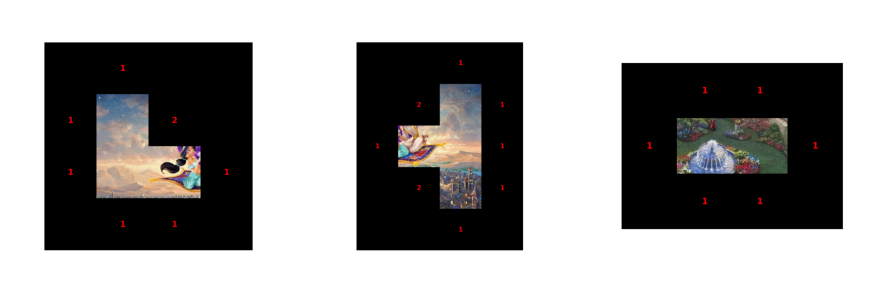

{0: [1, 1], 4: [2, 1], 5: [2, 2]}
{1: [1, 1]}
{2: [1, 1]}
{6: [2, 1], 3: [1, 2], 7: [2, 2], 11: [3, 2]}
{8: [1, 1]}
{9: [1, 1]}
{10: [1, 1]}
{12: [1, 1]}
{13: [1, 1], 14: [1, 2]}
{15: [1, 1]}


In [4]:
for comp in sorted_sides_comparisons:
    if comp.score < 0.2:
        anchor_fragment_idx = comp.side1.fragment_idx
        pasted_fragment_idx = comp.side2.fragment_idx
        anchor_group_idx = fragment_idx_to_group_idx[anchor_fragment_idx]
        pasted_group_idx = fragment_idx_to_group_idx[pasted_fragment_idx]
        if anchor_group_idx != pasted_group_idx:
            if check_groups_shapes_for_merging(comp, groups[anchor_group_idx], groups[pasted_group_idx]):
                if does_merge_fit_within_bounds(comp,groups[anchor_group_idx], groups[pasted_group_idx]):
                    if check_all_group_matchings_scores(comp, groups[anchor_group_idx], groups[pasted_group_idx]):                        
                        merge_groups(comp, fragments, fragment_idx_to_group_idx, groups[anchor_group_idx], groups[pasted_group_idx])
                        update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_group_idx)
                        print(comp)
show_all_groups(groups, fragments)

for g in groups:
    print(g.fragment_positions)

   group_idx  nr_of_neighbours  row  col
0          0                 2    1    2
1          3                 2    1    1
2          3                 2    3    1
anchor group idx: 0 with space at 1 2
left: 0 right: None top: None bottom: 5
nr of neighbours: 2
[1, 3, 7, 6, 2, 12, 8, 11, 15, 9, 10, 14, 13]
[12.996039644447292, 2.513379303455936e+61, 5.547480745278721e+65, 2.7516673981316827e+71, 1.0828948245968758e+78, 2.6060222101951703e+79, 1.2227885603425532e+82, 6.436151726458709e+86, 7.4408490469102375e+87, 4.9440042660403426e+88, 4.854578977758239e+89, 3.715614158869658e+90, 2.2476215754989266e+93]


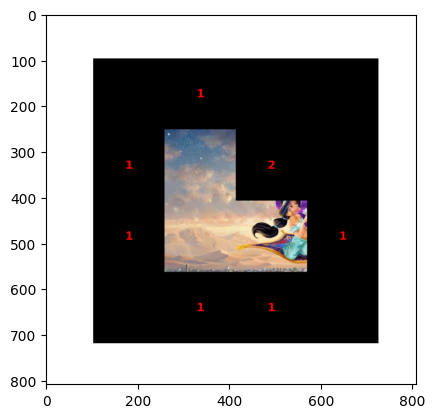

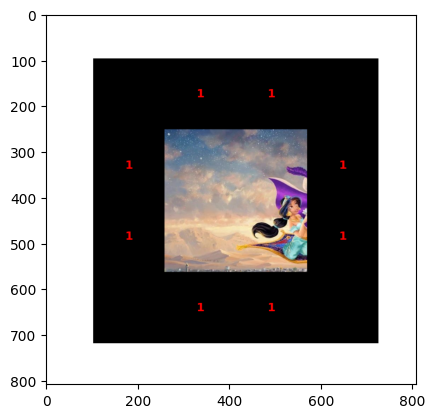

Merged using comp: Sides Comp: Score=12.985139413124745 Fragment_idx1=5, Side_idx1=0; fragment_idx2=1, side_idx2=2
anchor group idx: 2 with space at 1 1
left: None right: 3 top: None bottom: 6
nr of neighbours: 2
[2, 0, 5, 1, 4, 12, 10, 13, 9, 14, 8, 15]
[0.5904602839444463, 9.352358796191813e+37, 2.850731960564447e+62, 2.2403738260641566e+73, 2.6648015849419098e+73, 2.2759811649701235e+74, 8.691626893759039e+74, 6.468873661723315e+83, 4.3466462943514755e+84, 2.11226065113478e+88, 2.552004373336004e+89, 2.1751145514608303e+93]


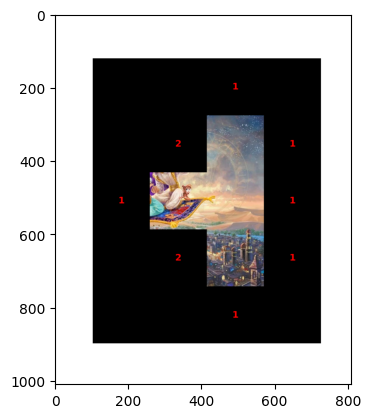

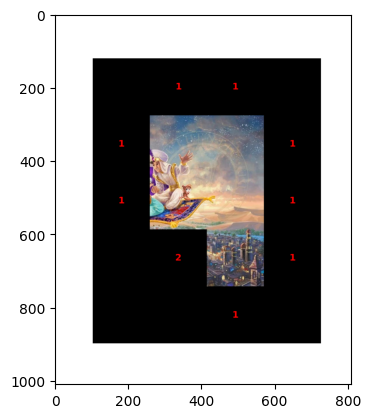

Merged using comp: Sides Comp: Score=0.5802802419134818 Fragment_idx1=6, Side_idx1=0; fragment_idx2=2, side_idx2=2
anchor group idx: 1 with space at 3 1
left: None right: 11 top: 6 bottom: None
nr of neighbours: 2
[10, 8, 9, 1, 14, 13, 0, 15, 5, 4, 12]
[1218761.215434205, 1.242151310368923e+41, 1.1358035524232508e+44, 2.496292774845799e+59, 1.536115179520026e+64, 8.992940459606443e+68, 1.479963826944865e+80, 2.752917766488627e+80, 2.288743229580344e+84, 6.706609476642422e+84, 2.095045863720892e+86]


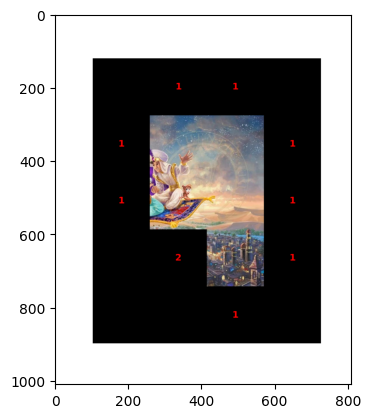

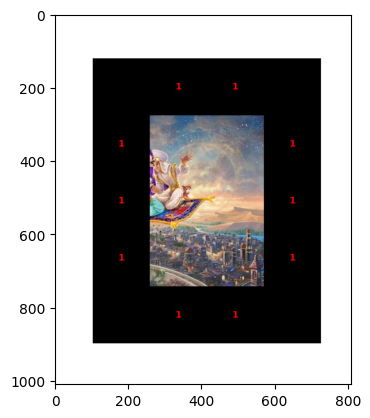

Merged using comp: Sides Comp: Score=1218727.8865318217 Fragment_idx1=6, Side_idx1=2; fragment_idx2=10, side_idx2=0


KeyError: 'nr_of_neighbours'

In [ ]:
edges_of_groups_df = edges_of_groups(groups)
print(edges_of_groups_df)
max_tiles = max(global_values.ROW_NR, global_values.COL_NR)

while len(groups) > 1 or len(edges_of_groups_df) == 0:
    for missing_spot_idx in range(len(edges_of_groups_df)):
    # missing_spot_idx = 0
        row_data = edges_of_groups_df.iloc[missing_spot_idx]

        anchor_group_idx = row_data["group_idx"]
        empty_row = row_data["row"]
        empty_col = row_data["col"]

        top_fragment_idx = None
        bottom_fragment_idx = None
        left_fragment_idx = None
        right_fragment_idx = None

        nr_of_neighbours = groups[anchor_group_idx].neighbours_grid[empty_row][empty_col]

        was_change = False
        ### find the edge fragments of the empty spot
        if empty_row-1 > 0:
            if groups[anchor_group_idx].grid[empty_row - 1][empty_col] is not None:
                top_fragment_idx = groups[anchor_group_idx].grid[empty_row - 1][empty_col]
        if empty_row + 1 < groups[anchor_group_idx].row_nr:
            if groups[anchor_group_idx].grid[empty_row + 1][empty_col] is not None:
                bottom_fragment_idx = groups[anchor_group_idx].grid[empty_row + 1][empty_col]
        if empty_col - 1 > 0:
            if groups[anchor_group_idx].grid[empty_row][empty_col - 1] is not None:
                left_fragment_idx = groups[anchor_group_idx].grid[empty_row][empty_col - 1]
        if empty_col + 1 < groups[anchor_group_idx].col_nr:
            if groups[anchor_group_idx].grid[empty_row][empty_col + 1] is not None:
                right_fragment_idx = groups[anchor_group_idx].grid[empty_row][empty_col + 1]

        print(f"anchor group idx: {anchor_group_idx} with space at {empty_row} {empty_col}")
        print(f"left: {left_fragment_idx} right: {right_fragment_idx} top: {top_fragment_idx} bottom: {bottom_fragment_idx}")
        print(f"nr of neighbours: {nr_of_neighbours}")

        score_dict = {}

        for fr_idx in range(len(fragments)):
            if fr_idx in groups[anchor_group_idx].used_fragments:
                continue

            score = 0
            valid = False
            best_comps = []

            if top_fragment_idx is not None:
                comp = get_comparison(top_fragment_idx, fr_idx, 2, 0)
                if comp:
                    score += comp.score
                    best_comps.append(comp)
                    valid = True
            if bottom_fragment_idx is not None:
                comp = get_comparison(bottom_fragment_idx, fr_idx, 0, 2)
                if comp:
                    score += comp.score
                    best_comps.append(comp)
                    valid = True
            if left_fragment_idx is not None:
                comp = get_comparison(left_fragment_idx, fr_idx, 1, 3)
                if comp:
                    score += comp.score
                    best_comps.append(comp)
                    valid = True
            if right_fragment_idx is not None:
                comp = get_comparison(right_fragment_idx, fr_idx, 3, 1)
                if comp:
                    score += comp.score
                    best_comps.append(comp)
                    valid = True

            if valid and best_comps:
                # Pick the best comparison (lowest score)
                best_comp = best_comps[0]
                score_dict[fr_idx] = (score, best_comp)


        # Sort by total score
        sorted_items = sorted(score_dict.items(), key=lambda x: x[1][0])
        sorted_indices = [idx for idx, (score, comp) in sorted_items]
        sorted_values = [score for idx, (score, comp) in sorted_items]
        sorted_comps = [comp for idx, (score, comp) in sorted_items]

        print(sorted_indices)
        print(sorted_values)

        if sorted_indices:
            pasted_group_idx = fragment_idx_to_group_idx[sorted_indices[0]]
            comp = sorted_comps[0]
            
            if check_groups_shapes_for_merging(comp, groups[anchor_group_idx], groups[pasted_group_idx]):
                if does_merge_fit_within_bounds(comp, groups[anchor_group_idx], groups[pasted_group_idx]):
                    new_group = groups[anchor_group_idx].show_group(fragments)
                    plt.imshow(new_group)
                    plt.show()
                    merge_groups(comp, fragments, fragment_idx_to_group_idx, groups[anchor_group_idx], groups[pasted_group_idx])
                    new_group = groups[anchor_group_idx].show_group(fragments)
                    plt.imshow(new_group)
                    plt.show()
                    update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_group_idx)
                    print("Merged using comp:", comp)

                    edges_of_groups_df = edges_of_groups(groups)
                    break

show_all_groups(groups, fragments)